In [1]:
# Import required packages
from keras.models import load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50, VGG16, InceptionV3
from keras.applications import inception_v3
from keras.applications import imagenet_utils
from keras.layers import Lambda

import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from keras.utils import to_categorical
from tqdm import tqdm
%matplotlib inline

Using TensorFlow backend.


## Method 1: Apply pre-trained model on training data but with new classifer

### Data Preparation

#### Steps
- Read input：cv2.imread
- Change image size：cv2.resize
- Define image type：cat = 0, dog = 1
- Shuffle the sequence of images and classification：shuffle
- Split training set into training and validation sets：train_test_split

In [2]:
shape = 224 # VGG16 input size = 224*224
label = np.array([0] * 12500 + [1] * 12500)
data = np.zeros((25000, shape, shape, 3), dtype=np.uint8)

for i in tqdm(range(12500)):
    img = cv2.imread('./train/cat.%s.jpg' % str(i))
    data[i] = cv2.resize(img, (shape, shape))
    
for i in tqdm(range(12500)):
    img = cv2.imread('./train/dog.%s.jpg' % str(i))
    data[i + 12500] = cv2.resize(img, (shape, shape))
    
print('Training Data Size = %.2f GB' % (sys.getsizeof(data)/1024**3))

100%|██████████| 12500/12500 [00:35<00:00, 348.52it/s]

Training Data Size = 3.50 GB


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.2, random_state=42)

In [4]:
test = np.zeros((12500, shape, shape, 3), dtype=np.uint8)
for i in tqdm(range(12500)):
    img = cv2.imread('./test/%s.jpg' % str(i + 1))
    test[i] = cv2.resize(img, (shape, shape))
print('Testing Data Size = %.2f GB' % (sys.getsizeof(test)/1024**3))

100%|██████████| 12500/12500 [00:35<00:00, 352.53it/s]

Testing Data Size = 1.75 GB


### Load the entire pre-trained model plus weights, replace with new classifier.

#### Steps
- Load pre-trained model and weight, excluding the original classifier
- Lock the layers of the pre-trained model to prevent the change during the training process: layers.trainable = False
- Add the new classifier to the end of the model. Choose sigmoid or softmax based on the number of types that need to classify
- Compire the model.Choose binary_crossentropy or categorical_crossentropy based on the number of types that need to classify
- Check the number of trainable weights: create function get_param_count() to count unlocked parameters
- Train the model
  - Use small batch size so that we can get high precision even with a few epochs
  - No need to use too many epochs, 5 ~ 10 is enough. Because the number of trainable parameters is small (~500), it can achieve the optimal without too many epochs.

**First I use VGG16 (22 layers) model for transfer learning.**

In [5]:
from keras import backend as K

def get_params_count(model):
    trainable = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    non_trainable = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))
    return trainable, non_trainable

In [6]:
# Preprocess the input
# Since the images are loaded by opencv, its default color channel is BGR. So we just need to substract the VGG mean from the data

# Method1 - use broadcasting to substract VGG mean
#x = Input(shape=(224, 224, 3))
#x = Lambda(lambda x:x-[103.939, 116.779, 123.68])(x)

# Method2 - use imagenet_utils.preprocess_input(). Note: we have to update Keras to 2.1.2, otherwise it won't work for symbolic tensors.
x = Input(shape=(224, 224, 3))
x = Lambda(imagenet_utils.preprocess_input)(x)

base_model = VGG16(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')


for layers in base_model.layers:
    layers.trainable = False

y = Dropout(0.5)(base_model.output)
y = Dense(1, activation='sigmoid')(y)

model1 = Model(inputs=base_model.input, outputs=y)
model1.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model1.summary()
print('Model has %d layers.' % len(model1.layers))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________

In [7]:
history = model1.fit(x=X_train, y=y_train, batch_size=16, epochs=5, validation_data=(X_val, y_val), shuffle=True)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 465s 23ms/step - loss: 0.9880 - acc: 0.8200 - val_loss: 0.1344 - val_acc: 0.9610
Epoch 2/5
20000/20000 [==============================] - 428s 21ms/step - loss: 0.3202 - acc: 0.9267 - val_loss: 0.1086 - val_acc: 0.9672
Epoch 3/5
20000/20000 [==============================] - 428s 21ms/step - loss: 0.2266 - acc: 0.9426 - val_loss: 0.0903 - val_acc: 0.9724
Epoch 4/5
20000/20000 [==============================] - 428s 21ms/step - loss: 0.1827 - acc: 0.9488 - val_loss: 0.0839 - val_acc: 0.9724
Epoch 5/5
20000/20000 [==============================] - 428s 21ms/step - loss: 0.1659 - acc: 0.9531 - val_loss: 0.0789 - val_acc: 0.9750


** Plot the accuracy and loss changes **

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


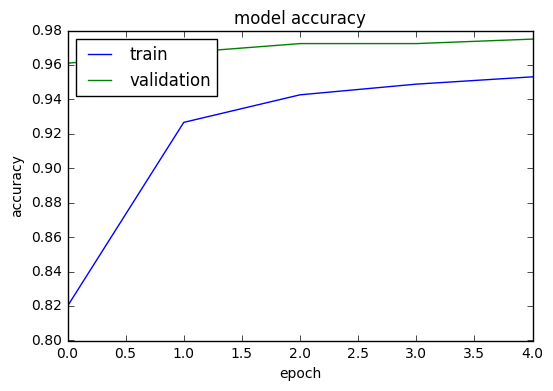

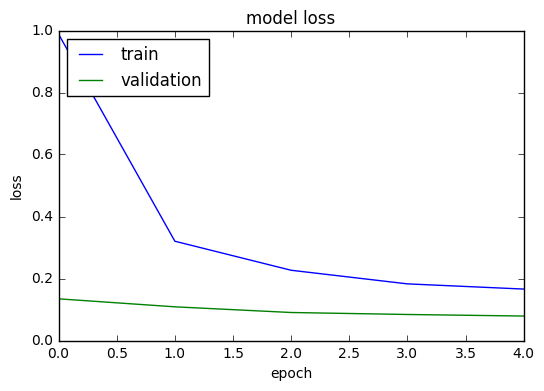

In [8]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Now let's try ResNet50 model (178 layers). **

In [9]:
#x = Input(shape=(224, 224, 3))
#x = Lambda(lambda x:x-[103.939, 116.779, 123.68])(x)

x = Input(shape=(224, 224, 3))
x = Lambda(imagenet_utils.preprocess_input)(x)

base_model = ResNet50(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')

for layers in base_model.layers:
    layers.trainable = False

y = Dropout(0.25)(base_model.output)
y = Dense(1, activation='sigmoid')(y)

model2 = Model(inputs=base_model.input, outputs=y)
model2.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model2.summary()
print('Model has %d layers.' % len(model2.layers))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        lambda_2[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
history = model2.fit(x=X_train, y=y_train, batch_size=16, epochs=5, validation_data=(X_val, y_val), shuffle=True)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 274s 14ms/step - loss: 0.1721 - acc: 0.9349 - val_loss: 0.0820 - val_acc: 0.9708
Epoch 2/5
20000/20000 [==============================] - 273s 14ms/step - loss: 0.1036 - acc: 0.9589 - val_loss: 0.0676 - val_acc: 0.9752
Epoch 3/5
20000/20000 [==============================] - 273s 14ms/step - loss: 0.0951 - acc: 0.9628 - val_loss: 0.0586 - val_acc: 0.9786
Epoch 4/5
20000/20000 [==============================] - 273s 14ms/step - loss: 0.0898 - acc: 0.9647 - val_loss: 0.0602 - val_acc: 0.9778
Epoch 5/5
20000/20000 [==============================] - 273s 14ms/step - loss: 0.0868 - acc: 0.9659 - val_loss: 0.0549 - val_acc: 0.9800


** Plot the accuracy and loss changes **

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


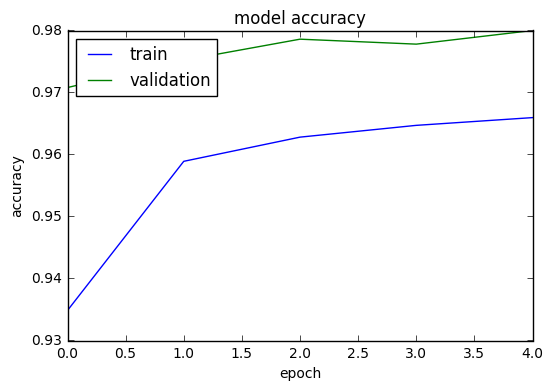

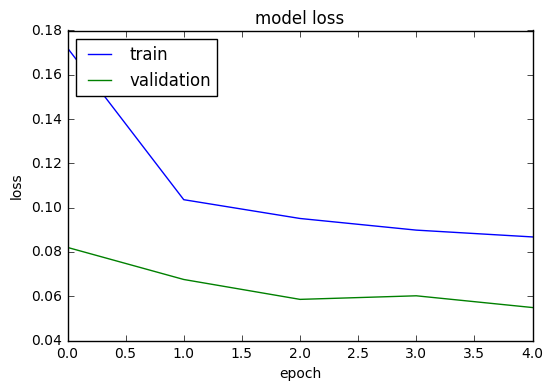

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Method 2: Apply pre-trained model on training data with new classifer and fine tune the last several layers

#### Steps
- Here I use the model2 created above. 
- Unblock the last several layers and train them.
- Since several layers form a combination (e.g. conv + batchNorm + acitvation), we'd better block/unblock the combination.
- Unblock the layers from high (output) to low (input). Train 5 epochs when unblocking on part. Then check if the loss and accuracy have improved. If the answer is yes, then we can continue training. Otherwise, we can unblock more layers until the training result has improvement.

In [12]:
model2.layers[-37:]

In [13]:
for layers in model2.layers[-35:]:
    layers.trainable = True
    
print('Trainable = %d, Non-Trainable = %d' % (get_params_count(model2)))

Trainable = 14453249, Non-Trainable = 9136512


In [14]:
model2.fit(x=X_train, y=y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val))

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 274s 14ms/step - loss: 0.0842 - acc: 0.9672 - val_loss: 0.0554 - val_acc: 0.9790
Epoch 2/10
20000/20000 [==============================] - 273s 14ms/step - loss: 0.0842 - acc: 0.9669 - val_loss: 0.0545 - val_acc: 0.9804
Epoch 3/10
20000/20000 [==============================] - 274s 14ms/step - loss: 0.0854 - acc: 0.9684 - val_loss: 0.0560 - val_acc: 0.9794
Epoch 4/10
20000/20000 [==============================] - 274s 14ms/step - loss: 0.0819 - acc: 0.9678 - val_loss: 0.0539 - val_acc: 0.9804
Epoch 5/10
20000/20000 [==============================] - 274s 14ms/step - loss: 0.0792 - acc: 0.9694 - val_loss: 0.0522 - val_acc: 0.9800
Epoch 6/10
20000/20000 [==============================] - 274s 14ms/step - loss: 0.0770 - acc: 0.9696 - val_loss: 0.0522 - val_acc: 0.9804
Epoch 7/10
20000/20000 [==============================] - 274s 14ms/step - loss: 0.0805 - acc: 0.9693 - val_loss: 0.0

In [15]:
model2.save('ResNet_Finetune_last3_epoch5.h5')

## Method 3: Multiple Model Integration

#### Steps

- Calculate feature vectors: calculate the output value of the entire training set from each model (excluding classifier part).
- Merge feature vectors: Merge the feature vectors from multiple models.
- Train the classifier
- Predict

### Calculate feature vectors

- Since I have already read the training and test datasets into memory, I can use model.predict() to get feature vectors directly.
- Average speed is 2 mins/per training + test feature vectors.

In [ ]:
import h5py
from keras.layers import Lambda

def export_gap(MODEL, preprocess=None):
    x = Input((224, 224, 3))
    if preprocess:
        x = Lambda(preprocess)(x)
    model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')

    train_gap = model.predict(data, batch_size=128)
    test_gap = model.predict(test, batch_size=128)
    
    with h5py.File("gap_%s.h5" % MODEL.__name__, 'w') as f:
        f.create_dataset('train', data=train_gap)
        f.create_dataset('test', data=test_gap)

In [ ]:
export_gap(VGG16, preprocess=imagenet_utils.preprocess_input)

In [ ]:
export_gap(ResNet50, preprocess=imagenet_utils.preprocess_input)

In [ ]:
# Note: the preprocessing method for InceptionV3 is different with VGG16 and ResNet50
export_gap(InceptionV3, preprocess=inception_v3.preprocess_input)

### Integrate feature vectors from different models

- Use np.concatenate to integrate vectors on specific dimension.
- Feed all feature vectors to the classifier which uses gradient descent to set weights automatically.

In [ ]:
train = []
test = []
for gapfile in ['gap_VGG16.h5', 'gap_ResNet50.h5', 'gap_InceptionV3.h5']:
    with h5py.File(gapfile, 'r') as f:
        train.append(np.array(f['train']))
        test.append(np.array(f['test']))
        
print('Feature Vector Shape for Model #0:', train[0].shape)

In [ ]:
X_train = np.concatenate(train, axis=1)
X_test = np.concatenate(test, axis=1)
print('Feature Vector Shape after Merging 2 models:', X_train.shape)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, label, test_size=0.2, random_state=42)

### Create Model

- We just need to define a simple classifier to classify the feature vectors. The output is 0(cat) or 1(dog).
- The input of this model is the merged output of above 3 feature vectors. So the input size is (None, 2048 * 3).

In [ ]:
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.25)(x)
y = Dense(1, activation='sigmoid')(x)

model_fusion = Model(inputs=inputs, outputs=y, name='Fusion')
model_fusion.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model_fusion.summary()

### Train the Model

- The total number of parameters of the model is about 6000 and the structure is very simple. The training time is very short.

In [ ]:
history = model_fusion.fit(x=X_train, y=y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val))

** Plot the accuracy and loss changes **

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Observation**

We can achieve better result using Fine tuning than feature vectors (0.0496 vs 0.0541). The key point is to 

### Predict the test set and upload result to Kaggle

- The judgment standard is LogLoss.
- Kaggle's scoring system will adjust the probability between 10^-15 and 1 - 10^-15)
- We change the output from 0/1 to 0.005/0.995 when the output is close to 0 or 1.


In [ ]:
y_pred = model_fusion.predict(X_test)
y_pred = y_pred.clip(min=0.005, max=0.995)

In [ ]:
y_pred.shape, y_pred[0]

In [ ]:
with open('test_tl.csv', 'w') as f:
    f.writelines('id,label\n')
    for i in range(12500):
        f.writelines(str(i+1) + ',' + str(y_pred[i][0]) + '\n')